In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

# from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import matplotlib.dates as mdates

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

import warnings
warnings.filterwarnings('ignore')

In [2]:
start = dt.datetime(2005,11,1)
end = dt.datetime(2024, 10, 31)

In [3]:
SPY_data = yf.download('SPY', start, end)

[*********************100%%**********************]  1 of 1 completed


In [4]:
SPY_momentum = SPY_data.copy()
SPY_momentum.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-11-01,120.580002,120.900002,120.220001,120.489998,83.991150,66365100
2005-11-02,120.169998,121.750000,120.129997,121.750000,84.869453,74012300
2005-11-03,122.150002,122.660004,121.750000,122.269997,85.231934,84897600


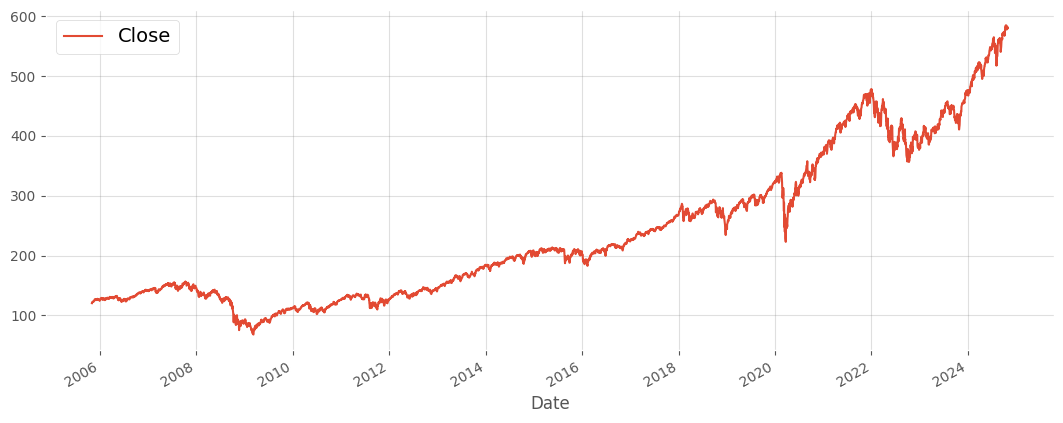

In [5]:
SPY_momentum[['Close']].plot(figsize = (13,5));

### 1. Overall idea when seeing the graph

* Overall the `SPY` displays an upward trend. Hence the momentum strategy using long-term parameters may work.
* We can see that there are some significant drops at the end of a cycle, before a new cycle occurs. Hence my idea is 1) first find strategies that maximize the Long entry, and 2) then add upper layers to hedging against these drops, or even exploit Short positions to maximize our wealth.
* So my proposed development is:\
a. First, employing MACD and tune the parameters to maximize the Long oppportunities.\
b. Identify the weakness of MACD and then add another strategy, such as the EWMA or VWAP to correct the MACD weaknesses.\
c. Find a strategy to hedge against the significant drops to minimize the Drawdowns.
* Also, I use the Volume-weighted Average Prices (VWAP) which accounts for the movements of volume overtime. A change in price that is accompanied by volume may indicate more convicing signals.

In [8]:
# Def a function to split the data set for future use

def test_train(df, bound):
    # Split the DataFrame
    split_index = int(len(df) * bound)
    train = df[:split_index]
    test = df[split_index:]
    return train, test

In [9]:
momentum_train, momentum_test = (test_train
                                 (SPY_momentum, 0.75))

### 2. Make some supplementary functions

In [11]:
# Generate basic positions (1: Long, -1: Short, 0: Neutral, Exit)

def strategy_positions(df, signal_col='MACD_Combined_Signals', strategy='long_short'):
    """
    Updates the Positions column based on the specified strategy.
    No trading fees applied here; positions are based on signals only.
    """

    df = df.copy()  # Avoid modifying the original DataFrame
    df['Positions'] = 0  # Initialize Positions to neutral value (0)

    # Iterate through the DataFrame for position logic
    for i in range(1, len(df)):
        prev_position = df['Positions'].iloc[i - 1]
        prev_signal = df[signal_col].iloc[i - 1]

        if strategy == 'long_only':
            # Long-only strategy logic
            if prev_position == 0 and prev_signal == 1:
                df['Positions'].iloc[i] = prev_signal  # Enter long position
            elif prev_position == 1 and prev_signal == -1:
                df['Positions'].iloc[i] = 0  # Exit position
            else:
                df['Positions'].iloc[i] = prev_position

        elif strategy == 'short_only':
            # Short-only strategy logic
            if prev_position == 0 and prev_signal == -1:
                df['Positions'].iloc[i] = prev_signal  # Enter short position
            elif prev_position == -1 and prev_signal == 1:
                df['Positions'].iloc[i] = 0  # Exit position
            else:
                df['Positions'].iloc[i] = prev_position

        elif strategy == 'long_short':
            # Long-short strategy logic
            if prev_position == 0 and prev_signal in [1, -1]:
                df['Positions'].iloc[i] = prev_signal  # Enter long or short position
            elif prev_position == 1 and prev_signal == -1:
                df['Positions'].iloc[i] = 0  # Exit long position
            elif prev_position == -1 and prev_signal == 1:
                df['Positions'].iloc[i] = 0  # Exit short position
            else:
                df['Positions'].iloc[i] = prev_position  # Maintain current position

    return df

In [12]:
# Basic performance metrics calculation

def strategy_summary(df, date_col='Date', positions='Positions', price_col='Price', strategy='long_only',
                     drawdown='max', timeframe=1, initial_capital=100000, plot=False):
    """
    Calculate some basic performance metrics as well as cumulative equity based on initial capital.
    """
    # ======== Strategy Calculation Section ========
    df['Price Return'] = np.log(df[price_col] / df[price_col].shift(1))
    df['Price Cum Return'] = df['Price Return'].cumsum().apply(np.exp)

    if strategy == 'long_only':
        current_position = df[positions].apply(lambda x: x if x > 0 else 0)
    elif strategy == 'short_only':
        current_position = df[positions].apply(lambda x: x if x < 0 else 0)
    elif strategy == 'long_short':
        current_position = df[positions]
    else:
        raise ValueError("Invalid strategy. Choose from 'long_only', 'short_only', or 'long_short'.")

    df['Strategy Return'] = df['Price Return'] * current_position
    df['Strategy Cum Return'] = df['Strategy Return'].cumsum().apply(np.exp)

    # Cumulative Equity Calculation
    df['Cumulative Equity'] = initial_capital * df['Strategy Cum Return']

    df['High Watermark'] = df['Strategy Cum Return'].cummax()
    df['Drawdown'] = (df['Strategy Cum Return'] - df['High Watermark']) / df['High Watermark']
    df['Max Drawdown'] = df['Drawdown'].cummin()

    # ======== Drawdown Calculation Section ========
    if df.index.name != date_col:
        df = df.set_index(date_col)

    if drawdown == 'current':
        last_zero_drawdown_date = df[df['Drawdown'] == 0].index[-1]
        current_drawdown_period = (df.index[-1] - last_zero_drawdown_date).days
        longest_drawdown_period_days = current_drawdown_period
        longest_drawdown_start = last_zero_drawdown_date
        longest_drawdown_end = df.index[-1]
    else:
        zero_drawdown_dates = df[df['Drawdown'] == 0].index
        if len(zero_drawdown_dates) > 1:
            drawdown_periods = [
                (zero_drawdown_dates[i], zero_drawdown_dates[i + 1])
                for i in range(len(zero_drawdown_dates) - 1)
            ]
            drawdown_durations = [(end - start).days for start, end in drawdown_periods]
            longest_drawdown_idx = np.argmax(drawdown_durations)
            longest_drawdown_period_days = drawdown_durations[longest_drawdown_idx]
            longest_drawdown_start, longest_drawdown_end = drawdown_periods[longest_drawdown_idx]
        else:
            longest_drawdown_period_days = 0
            longest_drawdown_start = None
            longest_drawdown_end = None

    max_drawdown = df['Drawdown'].min()

    if date_col != df.index.name:
        df = df.reset_index()

    # ======== Analytics Section ========
    analytics = pd.Series({
        'Sharpe Ratio': round(np.sqrt(252 * timeframe) * (df['Strategy Return'].mean() / df['Strategy Return'].std()), 2),
        'Price Cumulative Return (%)': round((df['Price Cum Return'].iloc[-1] - 1) * 100, 2),
        'Strategy Cumulative Return (%)': round((df['Strategy Cum Return'].iloc[-1] - 1) * 100, 2),
        'Price CAGR (%)': round((df['Price Cum Return'].iloc[-1] ** (252 * timeframe / len(df)) - 1) * 100, 2),
        'Strategy CAGR (%)': round((df['Strategy Cum Return'].iloc[-1] ** (252 * timeframe / len(df)) - 1) * 100, 2),
        'Max Drawdown (%)': round(max_drawdown * 100, 2),
        'Longest Drawdown Period': f"{longest_drawdown_period_days} days" if longest_drawdown_period_days else "None",
        'Longest Drawdown Start Date': longest_drawdown_start.date() if longest_drawdown_start else "N/A",
        'Longest Drawdown End Date': longest_drawdown_end.date() if longest_drawdown_end else "N/A",
        'Cumulative Equity': round(df['Cumulative Equity'].iloc[-1], 2)  # Final cumulative equity
    })

    analytics_df = analytics.to_frame(name=strategy)

    # ======== Plotting Section ========
    if plot:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        df[['Price Return', 'Strategy Return']].plot(ax=axes[0, 0], style=['grey', 'orange'])
        axes[0, 0].set_title("Price Return vs Strategy Return")
        axes[0, 0].grid(True, alpha=0.3)

        df[['Price Cum Return', 'Strategy Cum Return']].plot(ax=axes[0, 1], style=['grey', 'orange'])
        axes[0, 1].set_title("Price Cum Return vs Strategy Cum Return")
        axes[0, 1].grid(True, alpha=0.3)

        df[['High Watermark']].plot(ax=axes[1, 0], style='darkblue', lw=1.5)
        df[['Strategy Cum Return']].plot(ax=axes[1, 0], style='orange')
        axes[1, 0].set_title("High Watermark vs Strategy Cum Return")
        axes[1, 0].grid(True, alpha=0.3)

        df['Drawdown'].plot(ax=axes[1, 1], color='red', alpha=0.7)
        axes[1, 1].fill_between(df.index, df['Drawdown'], color='red', alpha=0.3)
        axes[1, 1].set_title("Drawdowns")
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return df, analytics_df

### 3. Momentum strategy developments

#### 3.1. Layer 1: Using MACD to identify Long entries

In [15]:
def macd_strategy(df, price='Close', short_ema=12, long_ema=26, signal_ema=9,
                  min_periods=None, upper_MACD=1500, lower_MACD=-1500,
                  cross_days=3, plot=False, plot_window=None):

    # Create a copy of the DataFrame to avoid modifying the original data
    df_macd = df.copy()

    # Step 1: Define dynamic column names
    ema_short_col = f'EMA_{short_ema}'
    ema_long_col = f'EMA_{long_ema}'
    macd_col = f'MACD_{short_ema}_{long_ema}'
    macd_signal_col = f'MACD_line_{signal_ema}'
    macd_signal_name = f"MACD_Signals_{short_ema}_{long_ema}_{signal_ema}"
    long_term_macd_col = f'Long_term_MACD_{short_ema}_{long_ema}_{signal_ema}'

    # Step 2: Calculate the short and long EMAs
    df_macd[ema_short_col] = df_macd[price].ewm(span=short_ema, min_periods=min_periods, adjust=False).mean()
    df_macd[ema_long_col] = df_macd[price].ewm(span=long_ema, min_periods=min_periods, adjust=False).mean()

    # Step 3: Calculate the MACD and Signal Line
    df_macd[macd_col] = df_macd[ema_short_col] - df_macd[ema_long_col]
    df_macd[macd_signal_col] = df_macd[macd_col].ewm(span=signal_ema, min_periods=min_periods, adjust=False).mean()

    # Step 4: Drop initial NA values to remove noise before generating signals
    df_macd.dropna(inplace=True)

    # Step 5: Generate Basic MACD Cross signals
    df_macd[macd_signal_name] = np.where(df_macd[macd_col] > df_macd[macd_signal_col], 1, -1)

    # Step 6: Initialize Long-term MACD signal column
    df_macd[long_term_macd_col] = np.nan

    # Step 7: Long-term entry logic based on MACD crossover
    for i in range(max(21, cross_days), len(df_macd)):
        # SHORT Signal
        if (df_macd[macd_col].iloc[i - cross_days] > upper_MACD) and \
           all(df_macd[macd_col].iloc[i - j] < df_macd[macd_signal_col].iloc[i - j] for j in range(cross_days)):
            df_macd.at[df_macd.index[i], long_term_macd_col] = -1

        # LONG Signal
        elif (df_macd[macd_col].iloc[i - cross_days] < lower_MACD) and \
             all(df_macd[macd_col].iloc[i - j] > df_macd[macd_signal_col].iloc[i - j] for j in range(cross_days)) and \
             (df_macd[macd_col].iloc[i] == df_macd[macd_col].iloc[i - 15:i + 1].max()):
            df_macd.at[df_macd.index[i], long_term_macd_col] = 1

    # Fill remaining NaN values in Long_term_MACD with 0
    df_macd[long_term_macd_col].fillna(0, inplace=True)

    # ======== Plot if requested ========
    if plot:
        plot_data = df_macd if plot_window is None else df_macd.tail(plot_window)

        # Adjust height_ratios to give more space to each plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 2]}, sharex=True)

        # Plot Price with Long-term MACD signals on primary axis
        ax1.plot(plot_data.index, plot_data[price], label=f'Price ({price})', color='black', lw=1.5)

        # Apply shading based on Long_term_MACD signals using explicit bounds
        min_price = plot_data[price].min()
        max_price = plot_data[price].max()

        ax1.fill_between(plot_data.index, min_price, max_price,
                         where=(plot_data[long_term_macd_col] == 1), color='green', alpha=0.8, label="Long-term MACD Long")
        ax1.fill_between(plot_data.index, min_price, max_price,
                         where=(plot_data[long_term_macd_col] == -1), color='red', alpha=0.8, label="Long-term MACD Short")

        # Set title and labels
        fig.suptitle(f"{price.upper()} and MACD({short_ema}, {long_ema}, {signal_ema}) Long-term Entry Signals",
                      fontsize=14, color='darkblue')
        ax1.set_ylabel("Price")
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)

        # Plot MACD and MACD Signal line on secondary axis
        ax2.plot(plot_data.index, plot_data[macd_col], label=f'MACD Line ({short_ema}, {long_ema})', color='blue', lw=1.5)
        ax2.plot(plot_data.index, plot_data[macd_signal_col], label=f'MACD Signal Line ({signal_ema})', color='orange', lw=1.5)
        ax2.axhline(0, color='red', linestyle='--', lw=1, alpha=0.5)
        ax2.set_ylabel("MACD Value")
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)

        plt.xlabel("Date")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return df_macd

In [16]:
def macd_combined_signals(df, entry_col='Long_term_MACD_12_26_9', new_col='MACD_Combined_Signals', plot=False,
                          macd_col='MACD_12_26', macd_signal_col='MACD_line_9',
                          price='Close', plot_window=None):
    """
    Calculates a decaying signal in `new_col` based on initial entries from `entry_col`.
    """

    # Initialize new_col and MACD_1st_entry
    df[new_col] = np.nan
    df['MACD_1st_entry'] = np.nan

    # Step 1: Assign initial entries to `MACD_1st_entry` and `new_col`
    df.loc[df[entry_col] == 1, 'MACD_1st_entry'] = 1
    df.loc[df[entry_col] == -1, 'MACD_1st_entry'] = -1
    df[new_col] = df['MACD_1st_entry']  # where Long-term MACD tells 1/-1, then that is the 1st entry

    # Step 2: Fill remaining NaNs in `MACD_1st_entry` with 0
    df['MACD_1st_entry'].fillna(0, inplace=True)

    # Step 3: Forward-fill to maintain 100% position hold
    df[new_col] = df[new_col].ffill()

    # Step 4: Set remaining NaN values at the start of `new_col` to 0
    df[new_col] = df[new_col].fillna(0)

    # Plotting section
    if plot:
        plot_data = df if plot_window is None else df.tail(plot_window)

        # Plot price with entry and decayed signals
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 2]}, sharex=True)
        fig.suptitle(f"{price.upper()} and MACD Combined Signals", fontsize=14, color='darkblue')

        # Plot price with entry zones
        ax1.plot(plot_data.index, plot_data[price], color="black", lw=1.5, label=f"Price ({price})")
        ax1.fill_between(plot_data.index, plot_data[price].min(), plot_data[price].max(),
                         where=plot_data[entry_col] == 1, color="green", alpha=0.8, label="Long-term MACD Long")
        ax1.fill_between(plot_data.index, plot_data[price].min(), plot_data[price].max(),
                         where=plot_data[entry_col] == -1, color="red", alpha=0.8, label="Long-term MACD Short")

        # Overlay decayed signals with lower opacity
        ax1.fill_between(plot_data.index, plot_data[price].min(), plot_data[price].max(),
                         where=plot_data[new_col] > 0, color="green", alpha=0.2, label="Long Zone")
        ax1.fill_between(plot_data.index, plot_data[price].min(), plot_data[price].max(),
                         where=plot_data[new_col] < 0, color="red", alpha=0.2, label="Short Zone")

        ax1.set_ylabel("Price")
        ax1.legend(loc='upper left')
        ax1.grid(True)

        # Plot MACD and signal line on the second axis
        ax2.plot(plot_data.index, plot_data[macd_col], label="MACD", color="blue", lw=1.2)
        ax2.plot(plot_data.index, plot_data[macd_signal_col], label="MACD Signal", color="orange", lw=1.2)
        ax2.axhline(0, color="black", linestyle="--", lw=0.5)
        ax2.set_ylabel("MACD Value")
        ax2.legend(loc='upper left')
        ax2.grid(True)

        plt.tight_layout()
        plt.xlabel("Date")
        plt.show()

    return df

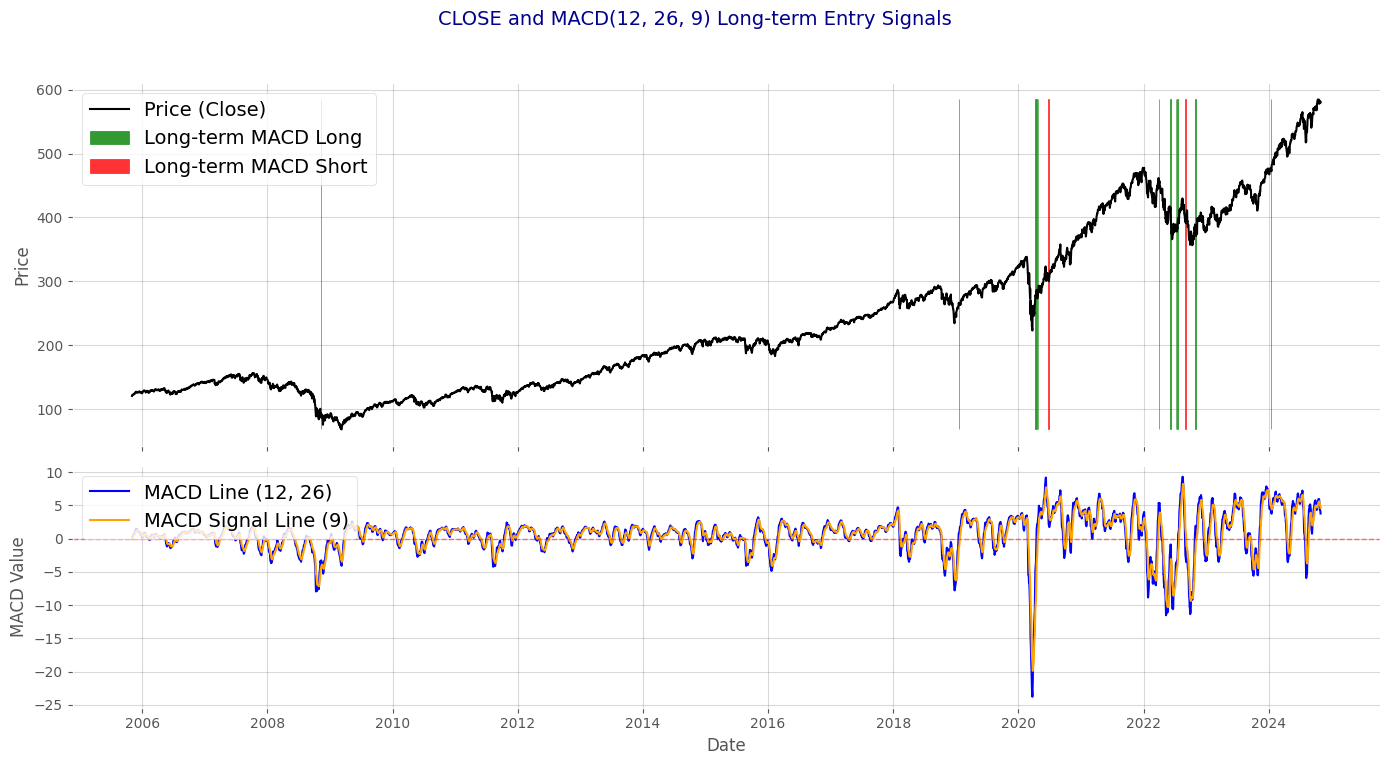

In [17]:
SPY_macd_entry = (macd_strategy(
    SPY_momentum, price = 'Close', short_ema=12, long_ema=26, signal_ema=9,min_periods=None,
    upper_MACD=7, lower_MACD=-5, cross_days=10, plot=True, plot_window=None))

In [18]:
SPY_macd_signals = (
    macd_combined_signals(SPY_macd_entry, entry_col='Long_term_MACD_12_26_9', new_col='MACD_Combined_Signals',
                          plot = False, macd_col='MACD_12_26', macd_signal_col='MACD_line_9',
                              price='Close'))

In [19]:
SPY_macd_positions = (strategy_positions(SPY_macd_signals, signal_col='MACD_Combined_Signals',
                                   strategy='long_only'))

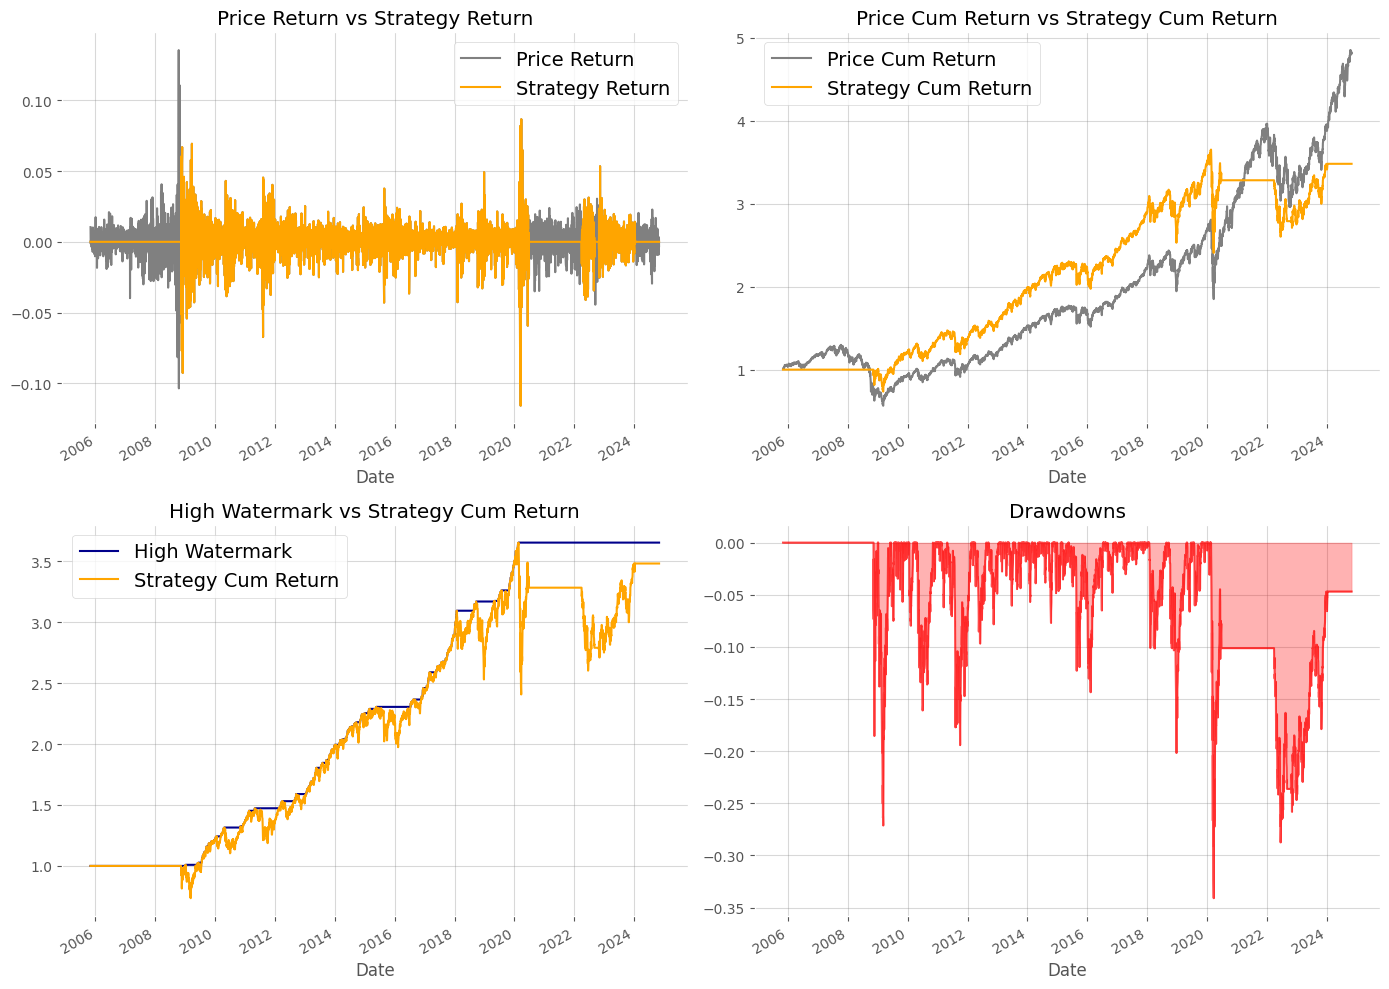

,long_only
Sharpe Ratio,0.41
Price Cumulative Return (%),381.38
Strategy Cumulative Return (%),248.12
Price CAGR (%),8.64
Strategy CAGR (%),6.8
Max Drawdown (%),-34.1
Longest Drawdown Period,1715 days
Longest Drawdown Start Date,2020-02-19
Longest Drawdown End Date,2024-10-30
Cumulative Equity,348116.37


In [20]:
SPY_macd_calc, SPY_macd_metrics = (
    strategy_summary(SPY_macd_positions, date_col='Date', positions='Positions', price_col='Close',
                     strategy='long_only', drawdown='current', timeframe=1, plot=True))

SPY_macd_metrics

* We can see that the MACD strategy with these parameters (tuned already) faces a trade off between a good Long entry with poor Short entry. At this point I decide to employ the EMA 200, 252 days strategy to enhance the performance (based on some logics and experience).

#### 3.2. Layer 2: Adding the EMA 200/252 and Volume-Weighted Average Price 200/252

In [23]:
def trend_252(data, price_col='Close', high_col='High', low_col='Low', volume_col='Volume',
              threshold=0.03, plot=False, plot_window=None):
    """
    Calculate rolling EWM and EMA for 200 and 252 days and assign combined trend signals.
    EWM uses the average of High, Low, and Close prices.
    Adds a 5% threshold condition for long/short signals.
    """
    df = data.copy()

    # Average Price
    df['Average_Price'] = (df[high_col] + df[low_col] + df[price_col]) / 3

    # Exponentially Weighted Moving Average (EWM)
    df['EWM_200'] = df['Average_Price'].ewm(span=200, adjust=False).mean()
    df['EWM_252'] = df['Average_Price'].ewm(span=252, adjust=False).mean()

    # Exponential Moving Average (EMA)
    df['EMA_200'] = df[price_col].ewm(span=200, adjust=False).mean()
    df['EMA_252'] = df[price_col].ewm(span=252, adjust=False).mean()

    # Slopes (raw differences)
    df['Slope_EWM_200'] = df['EWM_200'].diff()
    df['Slope_EWM_252'] = df['EWM_252'].diff()
    df['Slope_EMA_200'] = df['EMA_200'].diff()
    df['Slope_EMA_252'] = df['EMA_252'].diff()

    # Additional Conditions with % Threshold
    df['Above_Threshold'] = (df[price_col] > (1 + threshold) * df['EWM_200']) & (df[price_col] > (1 + threshold) * df['EWM_252']) & \
                            (df[price_col] > (1 + threshold) * df['EMA_200']) & (df[price_col] > (1 + threshold) * df['EMA_252'])
    df['Below_Threshold'] = (df[price_col] < (1 - threshold) * df['EWM_200']) & (df[price_col] < (1 - threshold) * df['EWM_252']) & \
                            (df[price_col] < (1 - threshold) * df['EMA_200']) & (df[price_col] < (1 - threshold) * df['EMA_252'])

    # Trend Signal
    df['Trend_252_Combined_Signals'] = np.nan
    uptrend_condition = (df['Slope_EWM_200'] > 0) & (df['Slope_EWM_252'] > 0) & \
                        (df['Slope_EMA_200'] > 0) & (df['Slope_EMA_252'] > 0) & \
                        df['Above_Threshold'] & df['Above_Threshold'].shift(1)
    downtrend_condition = (df['Slope_EWM_200'] < 0) & (df['Slope_EWM_252'] < 0) & \
                          (df['Slope_EMA_200'] < 0) & (df['Slope_EMA_252'] < 0) & \
                          df['Below_Threshold'] & df['Below_Threshold'].shift(1)

    df.loc[uptrend_condition, 'Trend_252_Combined_Signals'] = 1
    df.loc[downtrend_condition, 'Trend_252_Combined_Signals'] = -1
    df['Trend_252_Combined_Signals'] = df['Trend_252_Combined_Signals'].fillna(method='ffill').fillna(0)

    # Plot if required
    if plot:
        plot_data = df if plot_window is None else df.tail(plot_window)
        min_price = plot_data[price_col].min()
        max_price = plot_data[price_col].max()

        plt.figure(figsize=(13, 6))
        plt.plot(plot_data[price_col], label='Price', color='black', linewidth=1)
        plt.plot(plot_data['EWM_200'], label='EWM 200', color='blue', linestyle='--')
        plt.plot(plot_data['EWM_252'], label='EWM 252', color='cyan', linestyle='--')
        plt.plot(plot_data['EMA_200'], label='EMA 200', color='green', linestyle='-')
        plt.plot(plot_data['EMA_252'], label='EMA 252', color='orange', linestyle='-')

        plt.fill_between(plot_data.index, min_price, max_price,
                         where=(plot_data['Trend_252_Combined_Signals'] == 1), color='green', alpha=0.4, label='EWM/EMA 200/252 Long Entry')
        plt.fill_between(plot_data.index, min_price, max_price,
                         where=(plot_data['Trend_252_Combined_Signals'] == -1), color='red', alpha=0.4, label='EWM/EMA 200/252 Short Entry')

        plt.title(f'Price ({price_col}) and EWM/EMA 200/252 Entries with {threshold*100}% Threshold', color='darkblue', fontsize=14)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend(loc='upper left', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return df

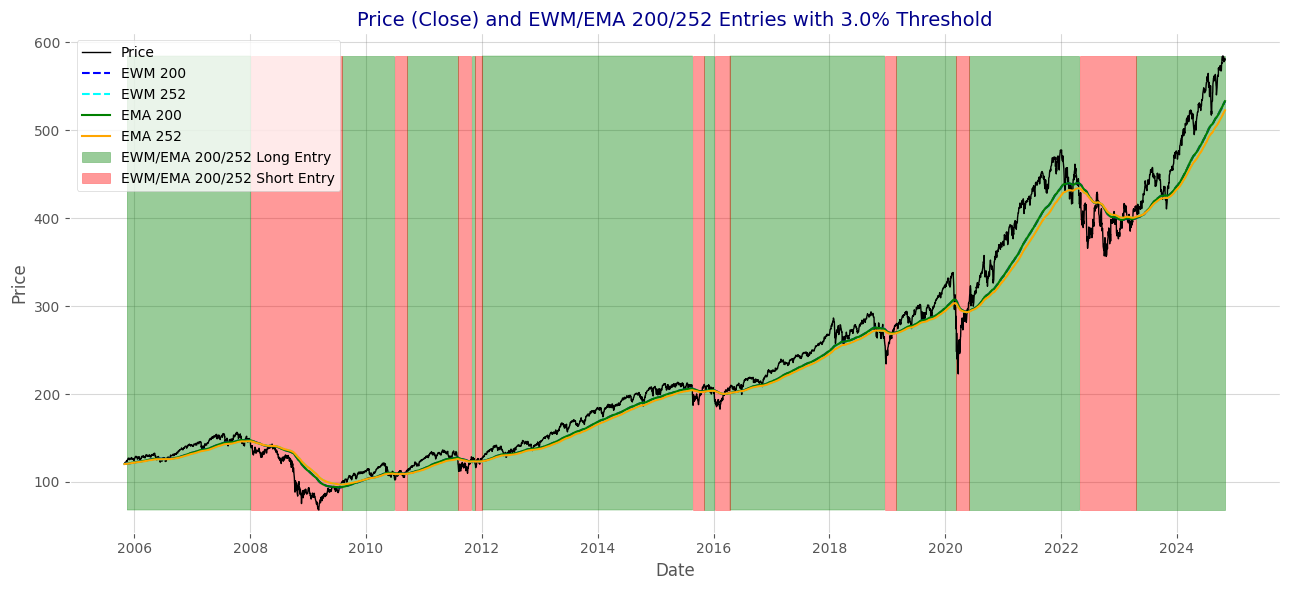

In [24]:
SPY_trend_252 = trend_252(SPY_momentum, price_col='Close', volume_col='Volume',
                          threshold=0.03, plot = True, plot_window = None)

* Comparing with MACD, I see that this `trend_252` strategy can complement `MACD_strategy`. As mentioned aboved, the weakness of `MACD_strategy` is its Short signals. Hence I set a logic here: use the Long signals of `MACD_strategy`; but for those positions that MACD say Short while `trend_252` say Long, then corrected that as Long.

In [26]:
def merge_strategy_long_override(df1, df2, col_1st, col_2nd, price_col, plot=False, plot_window=None):
    """
    Merge signals from two strategies:
    - 1st loop: Bring all signals from the first strategy.
    - 2nd loop: Override with long signals (1) if the second strategy says 1 while the first says -1.
    """
    df1 = df1.copy()
    df2 = df2.copy()
    merged_df = pd.DataFrame(index=df1.index)

    # Merge the price column for reference
    merged_df[price_col] = df1[price_col]

    # Initialize the combined signals column
    merged_df['Merge_signals_long_override'] = df1[col_1st]

    # Override with 1 if the first strategy says -1 and the second says 1
    merged_df.loc[(merged_df['Merge_signals_long_override'] == -1) & (df2[col_2nd] == 1), 'Merge_signals_long_override'] = 1

    # Plot if required
    if plot:
        plot_data = merged_df if plot_window is None else merged_df.tail(plot_window)
        min_price = plot_data[price_col].min()
        max_price = plot_data[price_col].max()

        plt.figure(figsize=(13, 6))
        plt.plot(plot_data[price_col], label='Price', color='black', linewidth=1)

        plt.fill_between(plot_data.index, min_price, max_price,
                         where=(plot_data['Merge_signals_long_override'] == 1), color='green', alpha=0.4, label='Long Signals (Override by 2nd Strategy)')
        plt.fill_between(plot_data.index, min_price, max_price,
                         where=(plot_data['Merge_signals_long_override'] == -1), color='red', alpha=0.4, label='Short Signals (1st Strategy)')

        plt.title(f'Price ({price_col}) and Merged Signals (Long Override)', color='darkblue', fontsize=14)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend(loc='upper left', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return merged_df

In [27]:
SPY_momentum_2_signals = merge_strategy_long_override(SPY_macd_signals, SPY_trend_252, 'MACD_Combined_Signals',
                   'Trend_252_Combined_Signals', 'Close', plot=False)

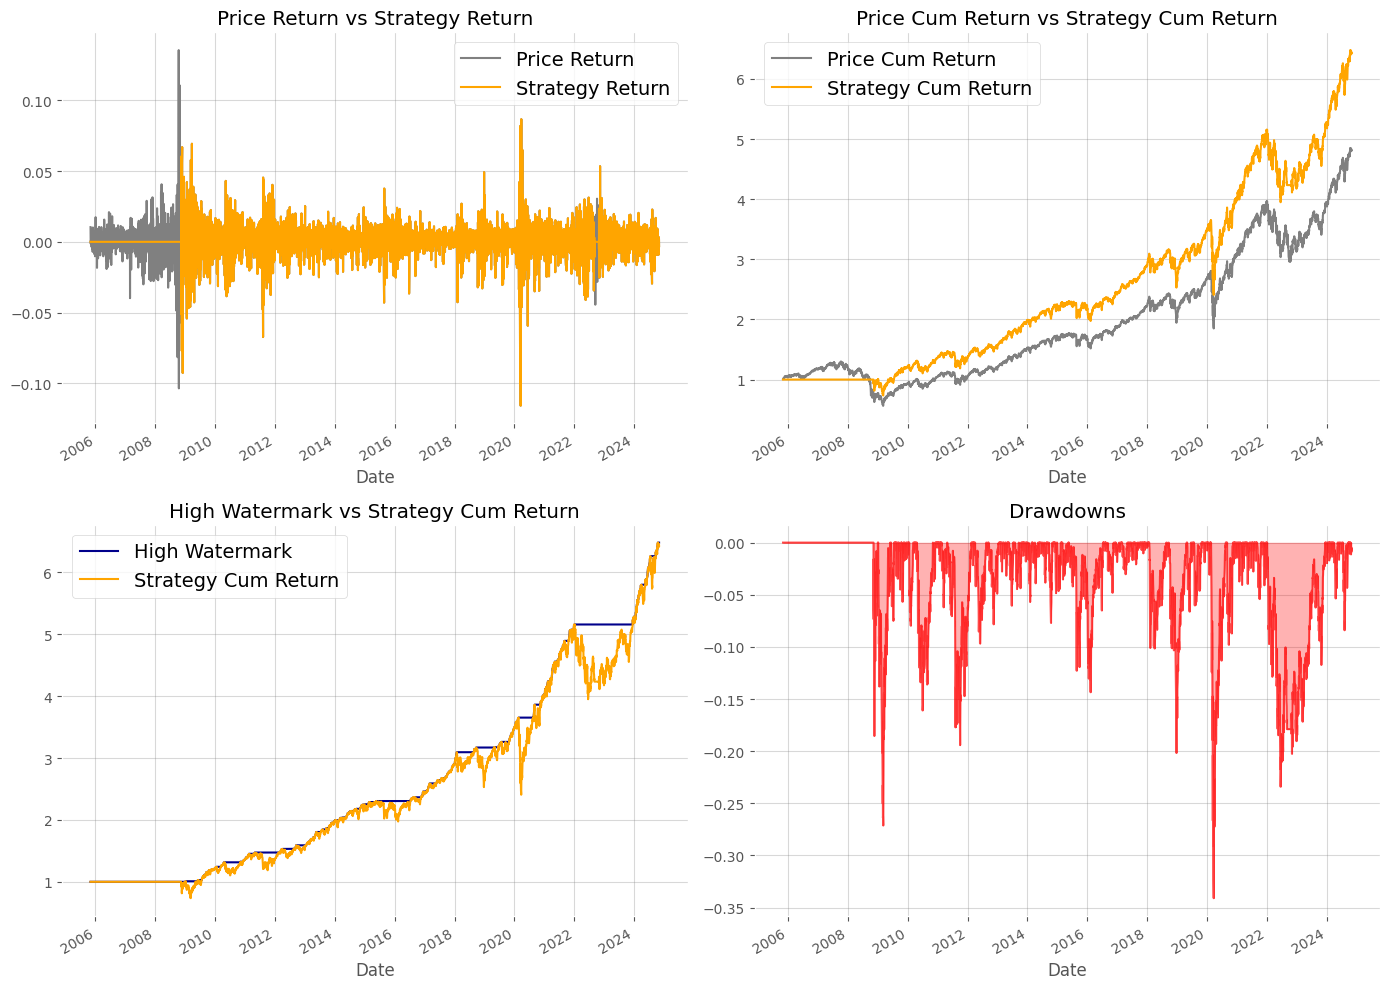

,long_only
Sharpe Ratio,0.58
Price Cumulative Return (%),381.38
Strategy Cumulative Return (%),542.91
Price CAGR (%),8.64
Strategy CAGR (%),10.31
Max Drawdown (%),-34.1
Longest Drawdown Period,709 days
Longest Drawdown Start Date,2022-01-03
Longest Drawdown End Date,2023-12-13
Cumulative Equity,642909.17


In [28]:
SPY_momentum_2_pos = (strategy_positions(SPY_momentum_2_signals, signal_col='Merge_signals_long_override',
                                   strategy='long_only'))

SPY_momentum_2_calc, SPY_momentum_2_metrics = (
    strategy_summary(SPY_momentum_2_pos, date_col='Date', positions='Positions', price_col='Close',
                     strategy='long_only', drawdown='max', timeframe=1, plot=True))

SPY_momentum_2_metrics

* We can see that the performance has been improved. But the hybrid strategy has not covered decently the signficant drops in the years 2020 and 2022.
* At this point, with the logics and institutions, I think that if there is a point that there is signficant spikes in return and volume, then we should not trade at the point but rather anticipate to stay neutral. These points may reflect the 'black swans' and we do not want to be greedy at those points.
* Hence my idea is:\
a. Define a customized strategy to find points with spikes in return and volume to hedge at those points, by either liquidate the portfolio or using hedging techniques.\
b. Combine the hybrid strategy with the new strategy: 1) apply the Long signals of the hybrid strategy, but 2) for points that the hybrid strategy above say 1 but the customized strategy say -1 then correct that points as -1.

#### 3.3. Layer 3: Defining a customized momentrum strategy to anticipate the signficant Shorts and exploit them

In [31]:
# I do log transform for all the OHLC data for my customized functions later

def log_return_calc(df, price_cols=['Open', 'High', 'Low', 'SP500'], volume_col='Volume'):
    """
    Calculate log returns for the given price columns while keeping the volume column unchanged.
    """
    log_return_df = df.copy()  # Create a copy to avoid modifying the original DataFrame

    # Calculate log returns for the specified columns
    for col in price_cols:
        log_return_df[f'Log_Return_{col}'] = np.log(log_return_df[col] / log_return_df[col].shift(1))

    # Keep the volume column unchanged
    log_return_df[volume_col] = df[volume_col]

    # Drop rows with NaN values resulting from the log return calculation
    log_return_df.dropna(inplace=True)

    return log_return_df

In [32]:
def spike_strategy(df, price_col='SP500', log_return_col='Log_Return_SP500', volume_col='Volume',
                   ewma_days=10, short_threshold=None, long_threshold=None, volume_break_threshold=None,
                   plot=False, plot_window=None):
    """
    Spike strategy combining log return thresholds, volume EWMA, and volume break conditions.
    """
    df_with_signals = df.copy()

    # Calculate EWMA of volume
    df_with_signals[f'Volume_EWMA_{ewma_days}'] = df_with_signals[volume_col].ewm(span=ewma_days, adjust=False).mean()

    # Calculate the volume break condition
    if volume_break_threshold is not None:
        df_with_signals['Volume_Break'] = df_with_signals[volume_col] > (1 + volume_break_threshold) * df_with_signals[f'Volume_EWMA_{ewma_days}']
    else:
        df_with_signals['Volume_Break'] = True  # Default to True if no threshold is set

    # Initialize signals column
    df_with_signals['Spike_Signals'] = 0

    # Apply short threshold logic with volume condition
    if short_threshold is not None:
        short_condition = (
            (df_with_signals[log_return_col] > short_threshold) &
            # (df_with_signals[log_return_col].shift(1) > short_threshold) &
            (df_with_signals['Volume_Break'])
        )
        df_with_signals.loc[short_condition, 'Spike_Signals'] = -1

    # Apply long threshold logic with volume condition
    if long_threshold is not None:
        long_condition = (
            (df_with_signals[log_return_col] < -long_threshold) &
            # (df_with_signals[log_return_col].shift(1) < -long_threshold) &
            (df_with_signals['Volume_Break'])
        )
        df_with_signals.loc[long_condition, 'Spike_Signals'] = 1

    # Ensure alignment and drop NA values if necessary
    df_with_signals['Spike_Signals'] = df_with_signals['Spike_Signals'].fillna(0).astype(int)

    # Plot if required
    if plot:
        plot_data = df_with_signals if plot_window is None else df_with_signals.tail(plot_window)

        fig, ax1 = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [4, 2]}, sharex=True)

        # First graph: Price above Log Return
        ax1[0].plot(plot_data.index, plot_data[price_col], label=f'Price ({price_col})', color='blue', lw=1.5, zorder=3)
        ax1[0].set_ylabel(f'Price ({price_col})', color='blue', fontsize=12)
        ax1[0].tick_params(axis='y', labelcolor='blue')
        ax1[0].grid(True, which='major', alpha=0.3, zorder=1)

        ax2 = ax1[0].twinx()
        ax2.plot(plot_data.index, plot_data[log_return_col], label=f'Log Return ({log_return_col})', color='orange', lw=1, alpha=0.7, zorder=2)
        ax2.set_ylabel(f'Log Return ({log_return_col})', color='orange', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='orange')

        # Add legend for both price and log return
        lines1, labels1 = ax1[0].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1[0].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

        # Highlight signals on the price chart
        ax1[0].scatter(plot_data.index[plot_data['Spike_Signals'] == 1],
                       plot_data[price_col][plot_data['Spike_Signals'] == 1],
                       label='Long Signal', color='green', marker='^', zorder=4)
        ax1[0].scatter(plot_data.index[plot_data['Spike_Signals'] == -1],
                       plot_data[price_col][plot_data['Spike_Signals'] == -1],
                       label='Short Signal', color='red', marker='v', zorder=4)

        # Second graph: Volume and EWMA
        ax1[1].bar(plot_data.index, plot_data[volume_col], label=f'Volume ({volume_col})', color='gray', alpha=0.7, zorder=1)
        ax1[1].plot(plot_data.index, plot_data[f'Volume_EWMA_{ewma_days}'], label=f'Volume EWMA ({ewma_days} Days)', color='purple', lw=1.5, zorder=2)
        ax1[1].set_ylabel('Volume', fontsize=12)
        ax1[1].set_xlabel('Date', fontsize=12)
        ax1[1].legend(loc='upper left', fontsize=10)
        ax1[1].grid(True, which='major', alpha=0.3)

        # Adjust layout
        plt.suptitle(f'{price_col} and Spike Strategy with Volume EWMA', fontsize=14, color='darkblue')
        plt.tight_layout()
        plt.show()

    return df_with_signals

In [33]:
SPY_log_data = log_return_calc(SPY_momentum,
                               price_cols=['Open', 'High', 'Low', 'Close'],
                               volume_col='Volume')

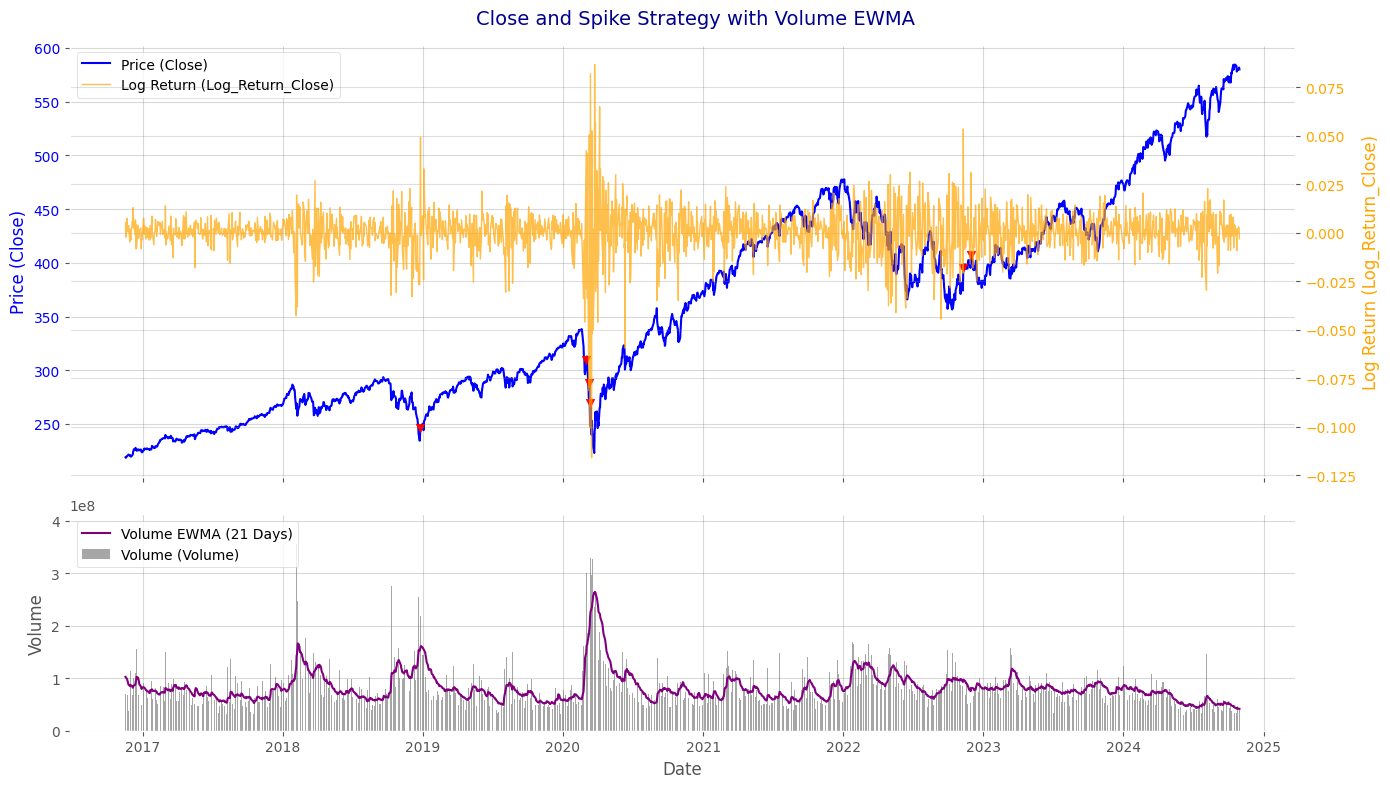

In [34]:
SPY_spike_signals = spike_strategy(SPY_log_data, price_col='Close', log_return_col='Log_Return_Close',
                                   volume_col='Volume', ewma_days=21, short_threshold=0.03,
                                   long_threshold=None, volume_break_threshold = 0.2, plot=True, plot_window=2000)

* We can that using our logic of 'panic' movements in both return and volumes, we may identify critical regions that require intensive hedging technique.
* Of course, there are still positions that this is not correct. However, none is perfect, and the main purpose of customizing this function is to cover the extreme case of 'black swans'.
* Now I use the same logic above to write another function to generate a hybrid strategy that combine the hybrid strategy above with this customized one to see if we can have a better outcome.

In [36]:
def merge_strategy_short_override(df1, df2, col_1st, col_2nd, price_col, plot=False, plot_window=None):
    """
    Merge signals from two strategies:
    - 1st loop: Bring all signals from the first strategy.
    - 2nd loop: Override with short signals (-1) if the second strategy says -1.

    Parameters:
    - df1 (pd.DataFrame): First DataFrame containing signals.
    - df2 (pd.DataFrame): Second DataFrame containing signals.
    - col_1st (str): Column name in df1 for the first strategy signals.
    - col_2nd (str): Column name in df2 for the second strategy signals.
    - price_col (str): Name of the price column for plotting.
    - plot (bool): Whether to plot the combined signals on the price.
    - plot_window (int): Number of recent data points to plot.

    Returns:
    - merged_df (pd.DataFrame): DataFrame with merged signals.
    """
    df1 = df1.copy()
    df2 = df2.copy()

    # Ensure indices are aligned
    if not df1.index.equals(df2.index):
        df2 = df2.reindex(df1.index)

    # Create merged DataFrame
    merged_df = pd.DataFrame(index=df1.index)

    # Merge the price column for reference
    merged_df[price_col] = df1[price_col]

    # Initialize the combined signals column
    merged_df['Merge_signals_short_override'] = df1[col_1st]

    # Override with -1 if the second strategy signals -1
    short_override_condition = (df2[col_2nd] == -1)
    merged_df.loc[short_override_condition, 'Merge_signals_short_override'] = -1

    # Plot if required
    if plot:
        plot_data = merged_df if plot_window is None else merged_df.tail(plot_window)
        min_price = plot_data[price_col].min()
        max_price = plot_data[price_col].max()

        plt.figure(figsize=(13, 6))
        plt.plot(plot_data[price_col], label='Price', color='black', linewidth=1)

        plt.fill_between(plot_data.index, min_price, max_price,
                         where=(plot_data['Merge_signals_short_override'] == 1), color='green', alpha=0.4, label='Long Signals (1st Strategy)')
        plt.fill_between(plot_data.index, min_price, max_price,
                         where=(plot_data['Merge_signals_short_override'] == -1), color='red', alpha=0.4, label='Short Signals (Override by 2nd Strategy)')

        plt.title(f'Price ({price_col}) and Merged Signals (Short Override)', color='darkblue', fontsize=14)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend(loc='upper left', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return merged_df

In [37]:
SPY_momentum_3_signals = merge_strategy_short_override(SPY_momentum_2_signals, SPY_spike_signals,
                                                     'Merge_signals_long_override', 'Spike_Signals',
                                                     'Close', plot=False, plot_window=None)

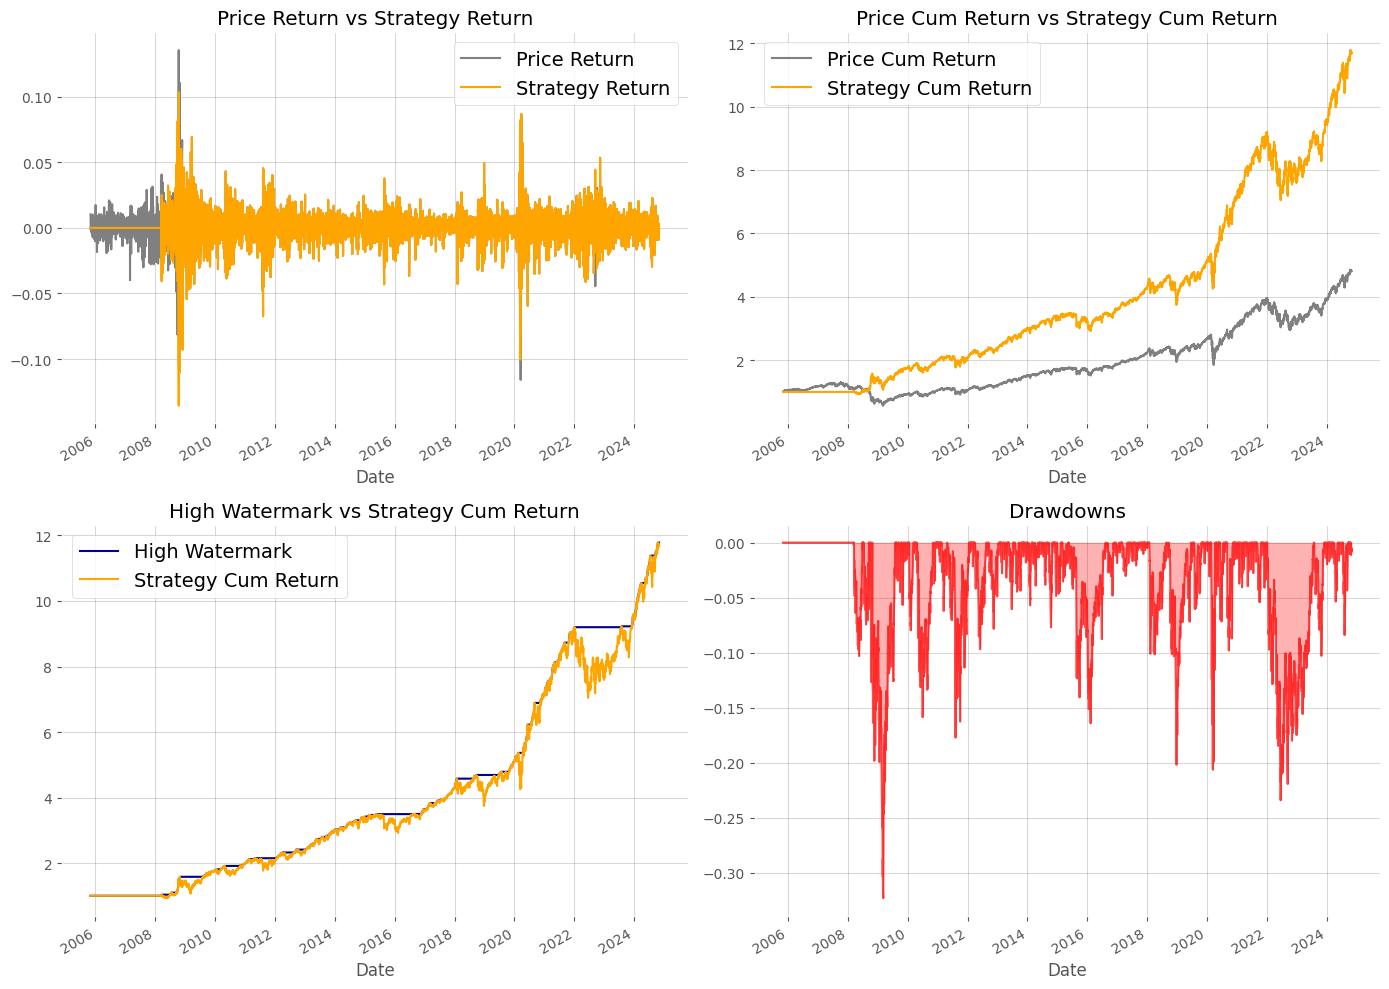

,long_short
Sharpe Ratio,0.7
Price Cumulative Return (%),381.38
Strategy Cumulative Return (%),1069.01
Price CAGR (%),8.64
Strategy CAGR (%),13.84
Max Drawdown (%),-32.32
Longest Drawdown Period,571 days
Longest Drawdown Start Date,2022-01-03
Longest Drawdown End Date,2023-07-28
Cumulative Equity,1169007.88


In [38]:
SPY_momentum_3_pos = (strategy_positions(SPY_momentum_3_signals, signal_col='Merge_signals_short_override',
                                   strategy='long_short'))

SPY_momentum_3_calc, SPY_momentum_3_metrics = (
    strategy_summary(SPY_momentum_3_pos, date_col='Date', positions='Positions', price_col='Close',
                     strategy='long_short', drawdown='max', initial_capital=100000, plot=True))
# Because we have enhanced the synergized strategy to cover both Long and Short, we should try with both sides in our trading

SPY_momentum_3_metrics

So for the whole period 2005-2004, with the hybrid strategy using only momentum concepts have:
- Sharpe: 0.71
- Cumulative return: 1070% vs Price return of 381%
- Strategy CAGR: 13.84% vs Price CAGR of 8.64%
- Max Drawdown: 32%
- From an intial equity of 100,000, we end up with 1,169,008.

## 4. Applying on the Test set

In [41]:
SPY_momentum_3_calc.tail()

,Close,Merge_signals_short_override,Positions,Price Return,Price Cum Return,Strategy Return,Strategy Cum Return,Cumulative Equity,High Watermark,Drawdown,Max Drawdown
Date,,,,,,,,,,,
2024-10-24,579.239990,1.0,1,0.002160,4.807370,0.002160,11.674559,1.167456e+06,11.782389,-0.009152,-0.323159
2024-10-25,579.039978,1.0,1,-0.000345,4.805710,-0.000345,11.670528,1.167053e+06,11.782389,-0.009494,-0.323159
2024-10-28,580.830017,1.0,1,0.003087,4.820566,0.003087,11.706606,1.170661e+06,11.782389,-0.006432,-0.323159
2024-10-29,581.770020,1.0,1,0.001617,4.828368,0.001617,11.725552,1.172555e+06,11.782389,-0.004824,-0.323159
2024-10-30,580.010010,1.0,1,-0.003030,4.813761,-0.003030,11.690079,1.169008e+06,11.782389,-0.007835,-0.323159


* We can simply split the performance DataFrame above into the 2nd part corresponding to the test set, and calculate cumulative performance metrics from that point.
* However, for intuitive verification, I re-run all the steps of the hybrid momentum strategy on the test data here.

In [43]:
momentum_test 
# My train and test uses 75:25 because for the 200/252 days strategy, which is equivalent to 1 trading year,
# if I used 80:20 then much data is lost

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-31,327.000000,327.170013,320.730011,321.730011,299.287720,113845600
2020-02-03,323.350006,326.160004,323.220001,324.119995,301.510895,69083000
2020-02-04,328.070007,330.010010,327.720001,329.059998,306.106354,62573200
2020-02-05,332.269989,333.089996,330.670013,332.859985,309.641266,65951100
2020-02-06,333.910004,334.190002,332.799988,333.980011,310.683197,50359700
...,...,...,...,...,...,...
2024-10-24,579.979980,580.059998,576.570007,579.239990,579.239990,34979900
2024-10-25,581.510010,584.460022,578.080017,579.039978,579.039978,47268200
2024-10-28,582.580017,582.710022,580.520020,580.830017,580.830017,30174700


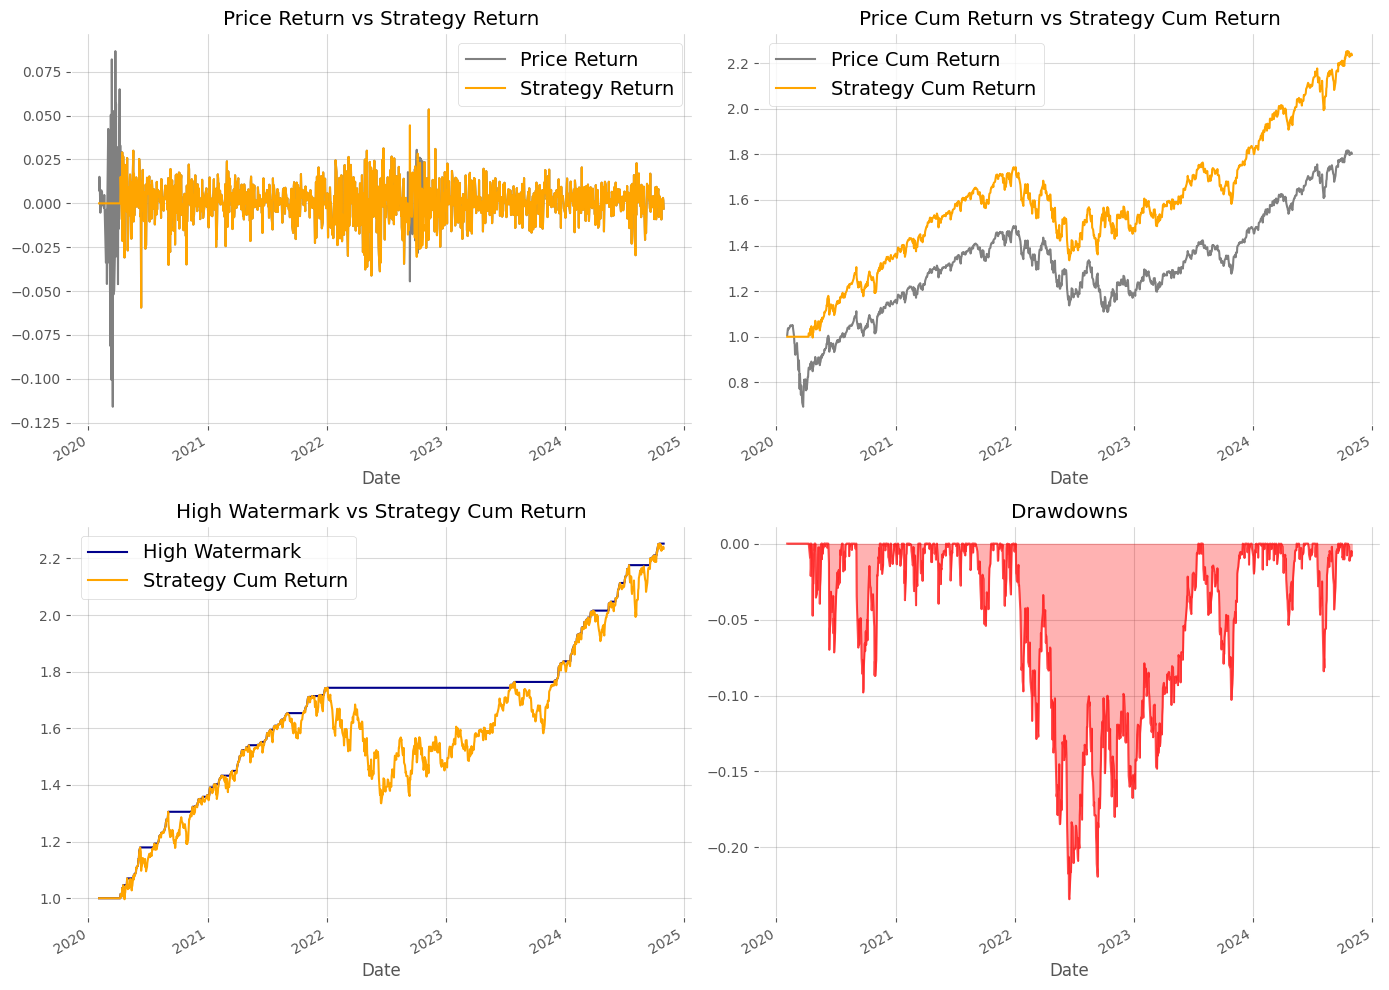

,long_short
Sharpe Ratio,1.0
Price Cumulative Return (%),80.28
Strategy Cumulative Return (%),123.49
Price CAGR (%),13.22
Strategy CAGR (%),18.46
Max Drawdown (%),-23.41
Longest Drawdown Period,561 days
Longest Drawdown Start Date,2022-01-03
Longest Drawdown End Date,2023-07-18
Cumulative Equity,223487.13


In [44]:
# Step 1: Implement the 1st layer of MACD strategy
SPY_test_macd_entry = (macd_strategy(
    momentum_test, price = 'Close', short_ema=12, long_ema=26, signal_ema=9,min_periods=None,
    upper_MACD=7, lower_MACD=-5, cross_days=10, plot=False))

SPY_test_macd_signals = (
    macd_combined_signals(SPY_test_macd_entry, entry_col='Long_term_MACD_12_26_9', new_col='MACD_Combined_Signals',
                          plot = False, macd_col='MACD_12_26', macd_signal_col='MACD_line_9', price='Close'))

# Step 2: Add 2nd layer of the 200/252 strategy
SPY_test_trend_252 = trend_252(momentum_test, price_col='Close', volume_col='Volume',
                          threshold=0.03, plot = False)

SPY_test_2_signals = merge_strategy_long_override(SPY_test_macd_signals, SPY_test_trend_252, 'MACD_Combined_Signals',
                   'Trend_252_Combined_Signals', 'Close', plot=False)

# Step 3: Add 3rd layer to anticipate spikes
SPY_test_log_data = log_return_calc(momentum_test,
                               price_cols=['Open', 'High', 'Low', 'Close'],
                               volume_col='Volume')

SPY_test_spike_signals = spike_strategy(SPY_test_log_data, price_col='Close', log_return_col='Log_Return_Close',
                                   volume_col='Volume', ewma_days=21, short_threshold=0.03,
                                   long_threshold=None, volume_break_threshold = 0.2, plot=False)

SPY_test_3_signals = merge_strategy_long_override(SPY_test_2_signals, SPY_test_spike_signals, 
                                                  'Merge_signals_long_override', 'Spike_Signals', 
                                                  'Close', plot=False)

SPY_test_3_pos = (strategy_positions(SPY_test_3_signals, signal_col='Merge_signals_long_override',
                                   strategy='long_short'))

# Step 4: Evaluate the performance
SPY_test_3_calc, SPY_test_3_metrics = (
    strategy_summary(SPY_test_3_pos, date_col='Date', positions='Positions', price_col='Close',
                     strategy='long_short', drawdown='max', initial_capital=100000, plot=True))

SPY_test_3_metrics

* We can see that despite a long drawdown period, the strategy even shows better performance in test set compared to the whole period.
* The Sharpe ratio is 1.0
* The strategy cumulative return is 123.5% vs price cumulative return of 80.3%.
* The strategy CAGR is 18.5% compared to price CAGR of 13.2%.
* The Max Drawdown is -23.41%.
* If we invest with 100,000 from 31 Jan 2020, we end up with 223,487 by October 2024.
* From the cumulative return graph, the gap between the strategy and price are increasingly larger overtime, which is a good sign.

## 5. Brief discussion

* No stragey is perfect. Each works on a specific condition. Hence, as a quant, we try best to have a diversified and deep unstanding of the available techniques. Following this, we can employ the techniques properly to enhanced certain circumstances.
* For the MACD strategy, the essential part is the parameters of the threshold as well as crossing conditions. This requires experiments, optimization and logics of the developer. For the current asset SPY, during this period there are about 3 different regimes that required some adjustment of these parameters. But in this assignment, I choose the one that fit well will a majority of states because it is just my 1st layer of strategy.
* As no strategy is fixed forever, hence dynamic adjustments, even day-by-day is not a big problem. Hence, for a period of 20 years with around 3-4 points to adjust the tuned parameters for MACD, then it is acceptable, especially when we consider its simplicity as well as computation expenditures compared to other state-of-the-art techniques.
* How do we anticipate there is a changes in the behaviour of MACD? The occurence of a signiciant spikes in the parameters  that has not appeared before or for  a long time. At these point, we should be conservative and anticipate that our parameters for MACD may not work at this regime. Hence, we may need to wait for more data to adjust. Otherwise, we should employ the hedging tools to protect our position.
* MACD also endures a problem of Short signals, but it works nice for Long signals, at least on this asset. To correct its weakness, I employ the `trend_252` strategy, which is basically another momentum strategy using EMA and VWAP 200/252 days. The reason of choosing these windows is about optimization. And when we think about the convergence of movement to the equilibrium point in any fields if we have sufficient data, then the cumulative effect of the previous 252 days is a good choice.
* The `spike_strategy` is one that I customize personally after some experiments and observations of the weakness of the combine strategy of `MACD` and `trend_252`. This works better for market index rather than a particular stock. At the points such that the overall market, which is the cumulative effects of all assets, indicates a spike in log return and volume, we may don't want to trade around that point. In real life trading, when that spike signals occur, we may liquidate our positions to stay neutral, or using heding techniques to render the portfolio neutral. We should not be greedy, but rather extremely conservative at those points as they may indicate significant shifts in the market regime.

<b>If ones have concerns regarding the parameter chosen in this notebook, then my simple answer is that we can write an Optimization function to solve back the parameters by choosing a particular objective function.<b>

* My gmail is binhnguyen.ibm@gmail.com
* For advance and complex models in practice, we can discuss for collaboration.
* Thank you.